In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, '/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraRGB/')
mask_path = os.path.join(path, '/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraSeg/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

FileNotFoundError: ignored

Text(0.5, 1.0, 'Segmentation')

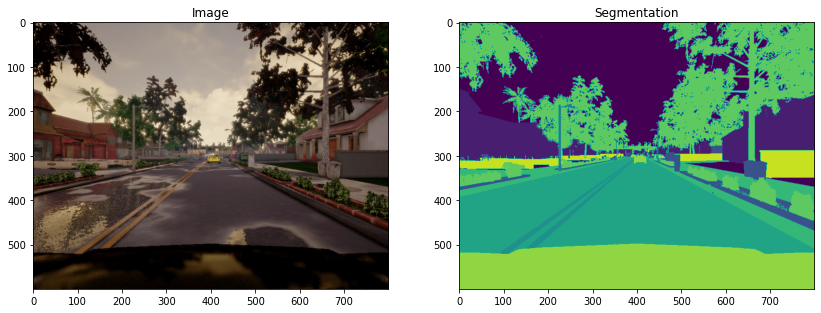

In [ ]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraRGB/F61-1.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraSeg/F61-1.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraRGB/F61-10.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraSeg/F61-10.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraRGB/F61-100.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraSeg/F61-100.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraRGB/F61-1.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraSeg/F61-1.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D()(conv)       
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)    
    return conv

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_21[0][0]']        

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(600, 800, 1)
(600, 800, 1)
(600, 800, 1)
(600, 800, 1)
(600, 800, 1)
(600, 800, 1)
(600, 800, 1)
(600, 800, 1)
(600, 800, 1)
(600, 800, 1)
(600, 800, 1)
(600, 800, 1)


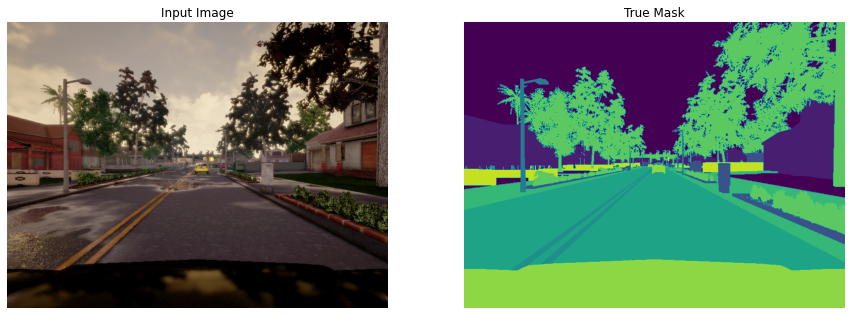

(96, 128, 1)


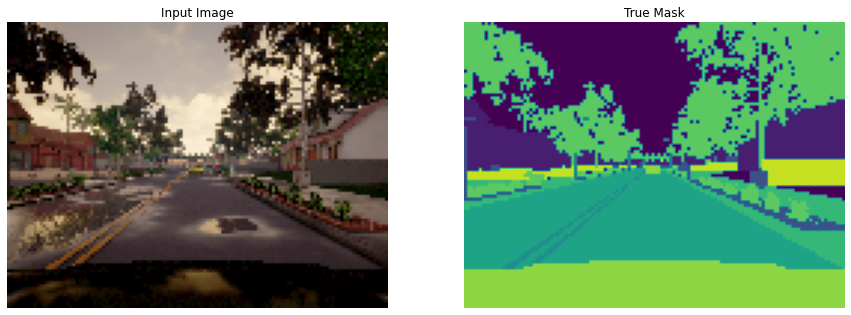

In [ ]:
for image, mask in image_ds.take(12):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
32/32 [==============================] - 553s 13s/step - loss: 3.4733 - accuracy: 0.2083
Epoch 2/40
32/32 [==============================] - 284s 9s/step - loss: 1.9870 - accuracy: 0.3084
Epoch 3/40
32/32 [==============================] - 283s 9s/step - loss: 0.9590 - accuracy: 0.6571
Epoch 4/40
32/32 [==============================] - 281s 9s/step - loss: 0.7712 - accuracy: 0.7205
Epoch 5/40
32/32 [==============================] - 281s 9s/step - loss: 0.6137 - accuracy: 0.7820
Epoch 6/40
32/32 [==============================] - 283s 9s/step - loss: 0.5539 - accuracy: 0.8074
Epoch 7/40
32/32 [==============================] - 282s 9s/step - loss: 0.5156 - accuracy: 0.8234
Epoch 8/40
32/32 [==============================] - 282s 9s/step - loss: 0.5010 - accuracy: 0.8316
Epoch 9/40
32/32 [==============================] - 284s 9s/step - loss: 0.4622 - accu

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
plt.plot(model_history.history["accuracy"])

NameError: ignored

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

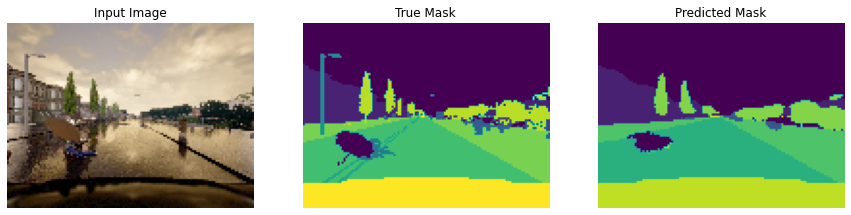

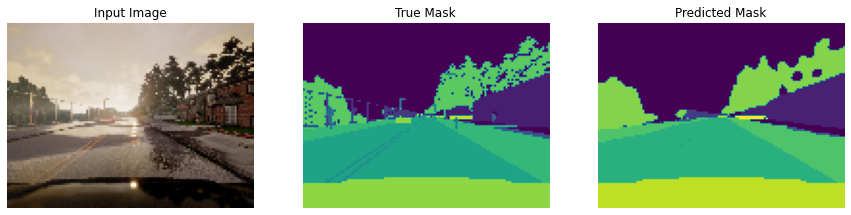

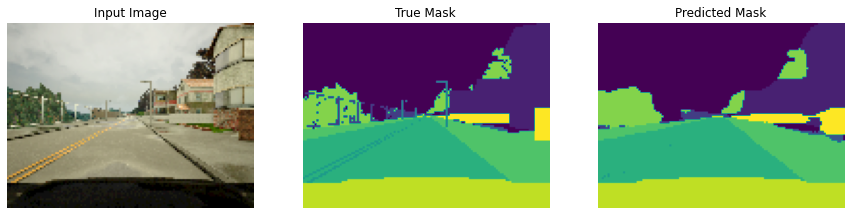

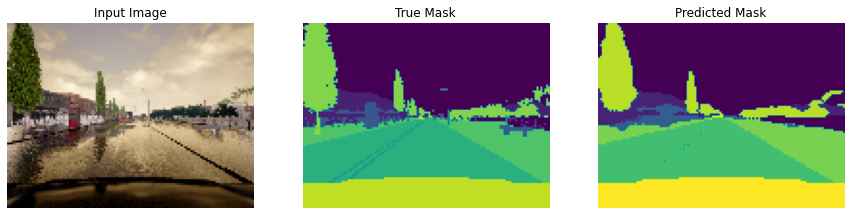

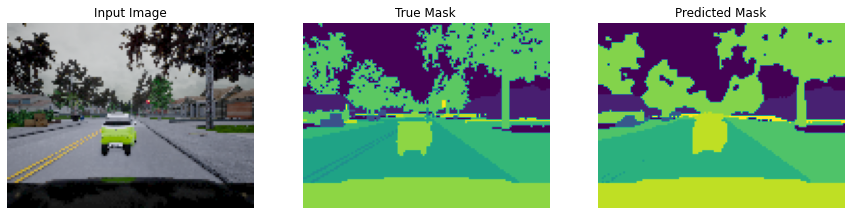

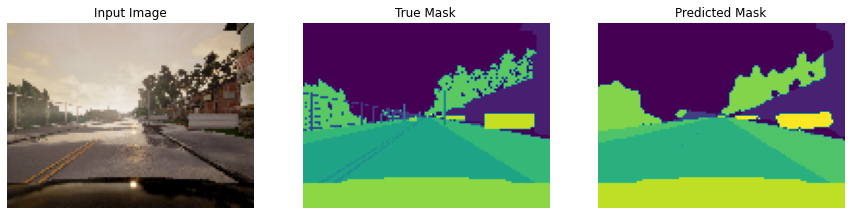

In [ ]:
show_predictions(train_dataset, 6)

In [ ]:
path = '/content/drive/MyDrive/TCC/OwlVision_semantic/'

tf.saved_model.save(unet, path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TCC/OwlVision_semantic/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TCC/OwlVision_semantic/assets


In [ ]:
unetSaved = tf.saved_model.load(path)

In [ ]:
print(unetSaved.signatures.get('serving_default'))

tf.saved_model.save(unetSaved, path, signatures=unetSaved.signatures.get('serving_default'))

ConcreteFunction signature_wrapper(*, input_2)
  Args:
    input_2: float32 Tensor, shape=(None, 96, 128, 3)
  Returns:
    {'conv2d_39': <1>}
      <1>: float32 Tensor, shape=(None, 96, 128, 23)
INFO:tensorflow:Assets written to: /content/drive/MyDrive/TCC/OwlVision_semantic/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TCC/OwlVision_semantic/assets


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(path) # path to the SavedModel directory
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('model_semantic.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
TFLITE_MODEL = "model_semantic.tflite"

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()
print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: serving_default_input_2:0
shape: [  1  96 128   3]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([  1,  96, 128,   3], dtype=int32), 'shape_signature': array([ -1,  96, 128,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

== Output details ==
name: StatefulPartitionedCall:0
shape: [  1  96 128  23]
type: <class 'numpy.float32'>

DUMP OUTPUT
{'name': 'StatefulPartitionedCall:0', 'index': 103, 'shape': array([  1,  96, 128,  23], dtype=int32), 'shape_signature': array([ -1,  96, 128,  23], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}